# SABR Volatility Surface Fitting and Interpolation for FX Options
---
## Summary

1. **Import Data**  
    - `full`: Main DataFrame containing FX option market data (currency, tenor, volatility, spot, date, delta).
    - `fwd_mult`: DataFrame with forward multipliers for each currency and tenor.

2. **Data Processing**  
    - Currencies with incomplete or malformed data are identified and excluded.
    - A processing function (`process_currency`) prepares forward rates and strikes for each currency.
    - The main fitting function (`fit_sabr_parameters`) iterates over all valid currencies, dates, and tenors, fitting SABR parameters using market data and storing results in a summary DataFrame (`matrix`).

3. **Parameter Fitting**  
    - The SABR model is calibrated for each currency/tenor/date combination.
    - Special handling is included for problematic currencies with known fitting issues.
    - Results include fitted parameters (`alpha`, `rho`, `nu`), forward rates, mean squared error, and the original market data points.

4. **Visualization of SABR Fits**  
    - The `visualize_fits` function plots SABR model fits for a sample of currencies, showing both the market data and the fitted volatility smile.
    - Mean squared error is annotated for each plot to assess fit quality.

5. **Comparison of Interpolation Methods**  
    - For a selected currency, tenor, and date, the notebook compares different interpolation methods (Cubic Spline, Piecewise Cubic Hermite) against the SABR model and market data.
    - Visual plots illustrate the fit and highlight differences between interpolation approaches.

6. **Export Data**  
    - The fitted SABR parameters for all surfaces are saved to `sabr_parameters.csv` for further analysis or downstream use.
    - The original FX volatility data is cleaned by mapping and removing invalid currencies.
    - The cleaned dataset is saved as `cleaned_fx_vol_data.csv`.

---

## Key Variables

- `full`: Main FX options volatility dataset.
- `fwd_mult`: Forward multipliers for each currency/tenor.
- `currencies`, `invalid`: Sets of valid and invalid currency codes.
- `dates_list`, `tenors_list`: Lists of available dates and tenors.
- `matrix`: DataFrame containing fitted SABR parameters and market data for each surface.
- `problematic_currencies`: List of currencies requiring special handling during fitting.
- `beta`: SABR model parameter (fixed at 0.75). Reached this number in preliminary testing stage by comparing mean-squared-errors at different betas.
- `dates_list`: Dates involved in this project span 3 work weeks from 12th to 30th August

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import PchipInterpolator, CubicSpline
from math import *
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
from Helper_Functions import *

In [2]:
# Import data
full = pd.read_csv('full_data_FXO.csv')
fwd_mult = pd.read_csv('fwd_multipliers.csv')

full.head()

,cur,tenor,vol,spot,date,delta
0,AUDBRL,0.25,0.1811,3.617,12,0.05
1,AUDBRL,0.25,0.1707,3.617,12,0.10
2,AUDBRL,0.25,0.1569,3.617,12,0.25
3,AUDBRL,0.25,0.1474,3.617,12,0.50
4,AUDBRL,0.25,0.1432,3.617,12,0.75


In [3]:
# Main Data Processing Functions

# Identify invalid currencies (due to missing data, etc.)
currencies = set(full.cur.values)
invalid = {'AUDNZD', 'EURRUB', 'EURTRY', 'USDHKD', 'USDTRY'}
for currency in currencies:
    if fwd_mult[fwd_mult.cur==currency].shape != (6, 3) or full[full['cur']==currency].shape != (630, 6):
        invalid.add(currency)
currencies = currencies - invalid
problematic_currencies = ['USDSAR', 'EURSGD', 'GBPSGD', 'EURTRY', 'EURRUB', 'GBPCHF'] #some currencies had issues with SABR fitting, so I used a different initial guess for them


def process_currency(currency, dates, tenors):
        # Prepare forward rates
        fwd_map = dict(zip(
            fwd_mult[fwd_mult['cur'] == currency].tenor,
            fwd_mult[fwd_mult['cur'] == currency].multiplier
        ))
        
        df = full[full['cur'] == currency].copy()
        df['fwd'] = df['spot'] * df['tenor'].map(fwd_map)
        df['strike'] = df.apply(get_strike, axis=1)
        
        return df
    
def fit_sabr_parameters(currencies, dates, tenors):
    #Fit SABR parameters for selected currencies, dates and tenors
    results = []
    
    for currency in currencies:
        df = process_currency(currency, dates, tenors)
        
        for date in dates:
            for tenor in tenors:
                smile = df[(df['date'] == date) & (df['tenor'] == tenor)]
                if smile.empty:
                    continue
                    
                strikes, vols = smile.strike.values, smile.vol.values
                fwd = smile.fwd.values[0]
                
                try:
                    # Initial guess adjustment for problematic currencies
                    guess = [0.1, 0, 2] if currency in problematic_currencies else [0.05, 0.1, 1]
                    alpha, rho, nu = fit(strikes, fwd, tenor, vols, guess)
                    mse = mserror(alpha, rho, nu, strikes, fwd, tenor, vols)
                    
                    results.append({
                        'currency': currency,
                        'date': date,
                        'tenor': tenor,
                        'alpha': alpha,
                        'rho': rho,
                        'nu': nu,
                        'fwd': fwd,
                        'mse': mse,
                        'strikes': strikes.tolist(),
                        'vols': vols.tolist()
                    })
                except Exception as e:
                    print(f'Error fitting {currency} {tenor}Y {date}: {str(e)}')
    
    return pd.DataFrame(results)

## Generate the matrix of SABR parameters


In [4]:
dates_list = sorted(set(full['date'].values)) 
tenors_list = sorted(set(full['tenor'].values))

matrix = []
matrix = fit_sabr_parameters(currencies=currencies, dates=dates_list, tenors=tenors_list)

print('Currencies Studied:', sorted(currencies))
matrix.head()

Currencies Studied: ['AUDCAD', 'AUDCHF', 'AUDJPY', 'AUDSEK', 'AUDSGD', 'AUDUSD', 'CADCHF', 'CADJPY', 'CADNOK', 'CADSEK', 'CHFJPY', 'CHFSEK', 'EURAUD', 'EURBRL', 'EURCAD', 'EURCHF', 'EURCZK', 'EURGBP', 'EURHUF', 'EURILS', 'EURJPY', 'EURMXN', 'EURNOK', 'EURNZD', 'EURPLN', 'EURSEK', 'EURSGD', 'EURUSD', 'EURZAR', 'GBPAUD', 'GBPCAD', 'GBPCHF', 'GBPJPY', 'GBPNOK', 'GBPNZD', 'GBPSEK', 'GBPSGD', 'GBPUSD', 'NZDCAD', 'NZDJPY', 'NZDUSD', 'SGDJPY', 'USDBRL', 'USDCAD', 'USDCHF', 'USDCNH', 'USDCNY', 'USDCZK', 'USDHUF', 'USDILS', 'USDINR', 'USDJPY', 'USDKRW', 'USDMXN', 'USDNOK', 'USDPHP', 'USDPLN', 'USDSAR', 'USDSEK', 'USDSGD', 'USDTWD', 'USDZAR']


,currency,date,tenor,alpha,rho,nu,fwd,mse,strikes,vols
0,EURNOK,12,0.25,0.163052,0.350583,1.048170,11.8365,0.000003,"[13.039928472114957, 12.699754618162556, 12.24...","[0.1157, 0.1076, 0.0978, 0.0896, 0.0863, 0.086..."
1,EURNOK,12,0.50,0.157694,0.374116,0.798983,11.8764,0.000002,"[13.640994699855344, 13.128194142269866, 12.46...","[0.1162, 0.1074, 0.0959, 0.087, 0.0834, 0.0832..."
2,EURNOK,12,0.75,0.155176,0.345415,0.691335,11.9161,0.000006,"[14.136800246834422, 13.476378560113844, 12.63...","[0.1164, 0.107, 0.0948, 0.0858, 0.083, 0.0837,..."
3,EURNOK,12,1.00,0.155241,0.368102,0.606291,11.9535,0.000006,"[14.612868873007805, 13.813972805861992, 12.80...","[0.1179, 0.1083, 0.0955, 0.0859, 0.0826, 0.083..."
4,EURNOK,12,2.00,0.158311,0.390784,0.424162,12.0707,0.000010,"[16.192992270736326, 14.92225124718707, 13.375...","[0.1201, 0.1103, 0.0976, 0.0875, 0.0842, 0.084..."


## Visualise Fits of SABR Params

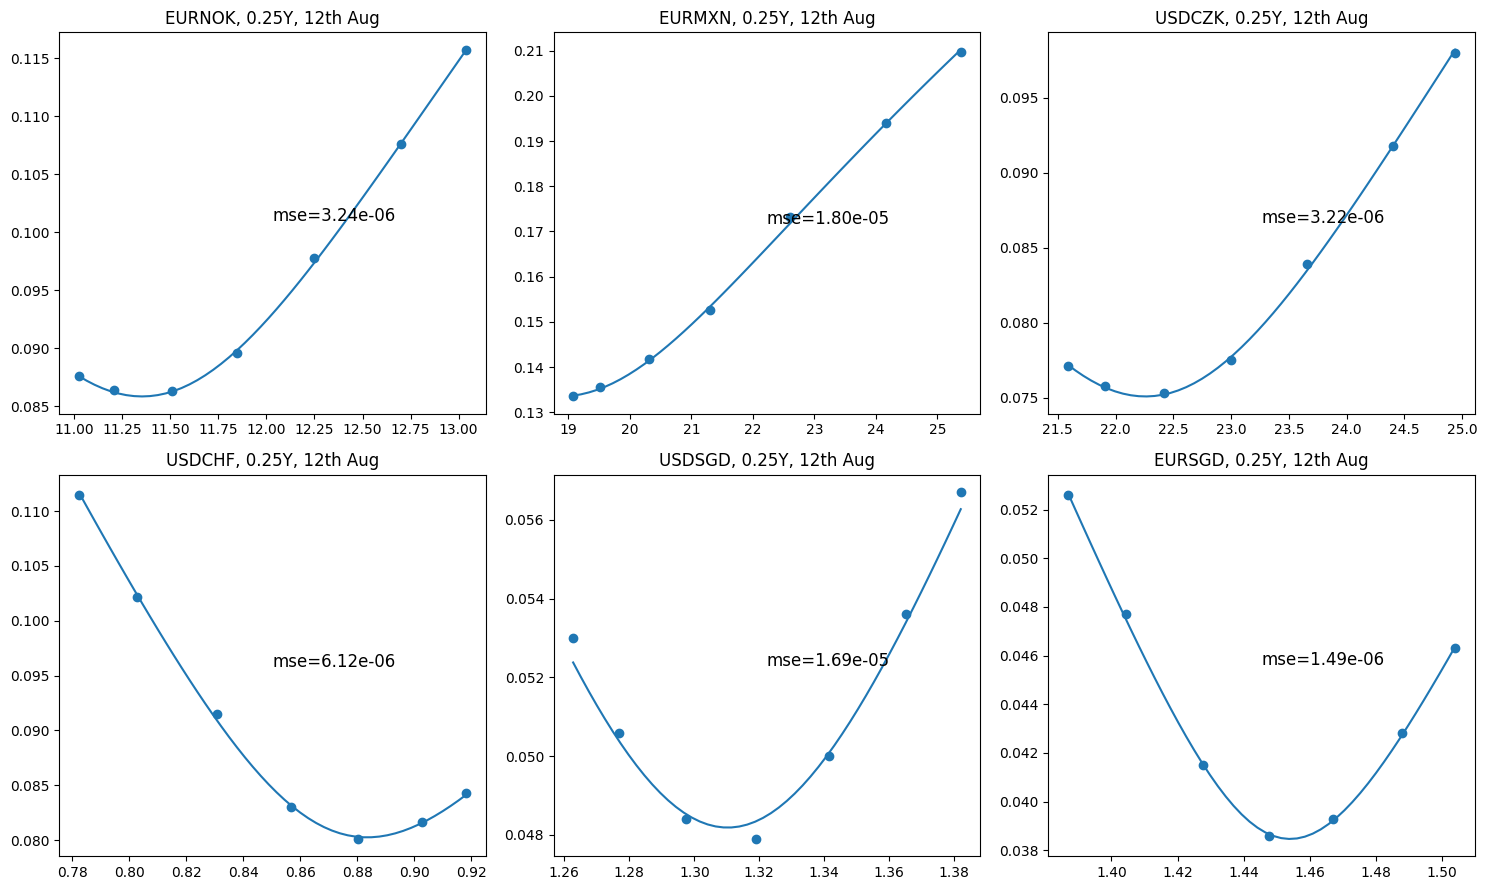

In [5]:
def visualize_fits(results_df, n_plots: int = 6) -> None:
        """Visualize SABR fits for sample currencies."""
        sample_currencies = results_df['currency'].unique()[:n_plots]
        fig, axes = plt.subplots(2, 3, figsize=(15, 9))
        axes = axes.flatten()
        
        for i, currency in enumerate(sample_currencies):
            sample = results_df[results_df['currency'] == currency].iloc[0]
            strikes = np.array(sample['strikes'])
            vols = np.array(sample['vols'])
            fwd = sample['fwd']
            tenor = sample['tenor']
            date = sample['date']
            alpha, rho, nu = sample['alpha'], sample['rho'], sample['nu']
            
            sabr_strikes = np.linspace(max(strikes), min(strikes), 50)
            sabr_vols = [lognormal_vol(k, fwd, tenor, alpha, beta, rho, nu) 
                        for k in sabr_strikes]
            
            axes[i].text(
                (min(strikes) + max(strikes))/2, 
                (min(vols) + max(vols))/2, 
                f'mse={sample["mse"]:.2e}', 
                fontsize=12
            )
            axes[i].scatter(strikes, vols)
            axes[i].plot(sabr_strikes, sabr_vols)
            axes[i].set_title(f'{currency}, {tenor}Y, {date}th Aug')
        
        plt.tight_layout()
        plt.show()

visualize_fits(matrix)

## Comparison of interpolation methods

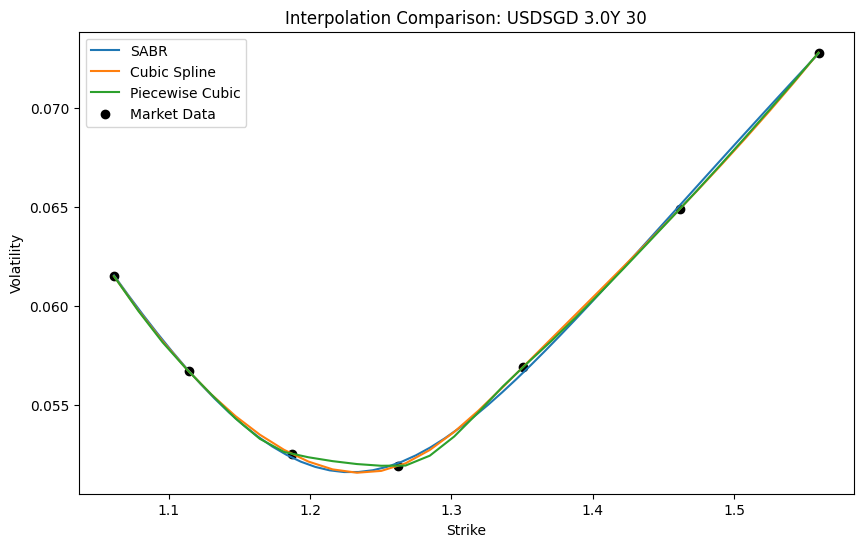

In [6]:
def compare_interpolation(currency, tenor, date, matrix_df):
    params = matrix_df[
        (matrix_df['currency'] == currency) & 
        (matrix_df['tenor'] == tenor) & 
        (matrix_df['date'] == date)
    ].iloc[0]
    
    strikes = np.array(params['strikes'])
    vols = np.array(params['vols'])
    fwd = params['fwd']
    alpha, rho, nu = params['alpha'], params['rho'], params['nu']
    
    # Create interpolators
    cs = CubicSpline(np.flip(strikes), np.flip(vols))
    poly = PchipInterpolator(np.flip(strikes), np.flip(vols))
    
    # Evaluation points
    eval_strikes = np.linspace(min(strikes), max(strikes), 30)
    cs_vols = cs(eval_strikes)
    poly_vols = poly(eval_strikes)
    
    # SABR volatilities
    sabr_strikes = np.linspace(max(strikes), min(strikes), 50)
    sabr_vols = [lognormal_vol(k, fwd, tenor, alpha, beta, rho, nu) 
                for k in sabr_strikes]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(sabr_strikes, sabr_vols, label='SABR')
    plt.plot(eval_strikes, cs_vols, label='Cubic Spline')
    plt.plot(eval_strikes, poly_vols, label='Piecewise Cubic')
    plt.scatter(strikes, vols, color='black', label='Market Data')
    
    plt.xlabel('Strike')
    plt.ylabel('Volatility')
    plt.title(f'Interpolation Comparison: {currency} {tenor}Y {date}')
    plt.legend()
    plt.show()

# Example interpolation comparison
compare_interpolation('USDSGD', 3.0, 30, matrix)

# Export

In [7]:
matrix.to_csv('sabr_parameters.csv', index=False)
map4 = {**dict(zip(currencies, currencies)), 
           **dict(zip(invalid, [float('Nan')]*len(invalid)))}
full['cur'] = full['cur'].map(map4)
full = full.dropna()
full.to_csv('cleaned_fx_vol_data.csv', index=False)